In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('Flight_Pricing_OneFlight.csv', parse_dates=['Dep_Date'])
df.head(2)

,Dep_Date,Days_to_Depart,Price,Comptt_Price_Median,Bookings
0,2011-01-01,60,7541.0,7529.91,3.0
1,2011-01-02,60,5032.0,4625.46,4.0


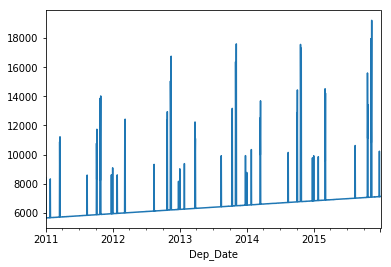

In [3]:
df.groupby('Dep_Date')['Price'].mean().plot()

In [3]:
df['day_of_month'] = df.Dep_Date.apply(lambda x: x.day)
df['month'] = df.Dep_Date.apply(lambda x: x.month)
df['weekday'] = df.Dep_Date.apply(lambda x: x.weekday())
df['Difference_To_Market'] = df.Price - df.Comptt_Price_Median
df['year'] = df.Dep_Date.apply(lambda x: x.year)
df['Sales'] = df['Bookings']*df['Price']

In [4]:
df.head(2)

,Dep_Date,Days_to_Depart,Price,Comptt_Price_Median,Bookings,day_of_month,month,weekday,Difference_To_Market,year,Sales
0,2011-01-01,60,7541.0,7529.91,3.0,1,1,5,11.09,2011,22623.0
1,2011-01-02,60,5032.0,4625.46,4.0,2,1,6,406.54,2011,20128.0


In [5]:
df.shape

(109560, 11)

In [6]:
analysis_df = df[df.Days_to_Depart==60][[col for col in df.columns if col not in ['Dep_Date','Days_to_Depart','Bookings','Comptt_Price_Median']]]
analysis_df.shape
analysis_df.head()

,Price,day_of_month,month,weekday,Difference_To_Market,year,Sales
0,7541.0,1,1,5,11.09,2011,22623.0
1,5032.0,2,1,6,406.54,2011,20128.0
2,5032.0,3,1,0,-26.02,2011,15096.0
3,5039.0,4,1,1,50.76,2011,50390.0
4,5055.0,5,1,2,-214.14,2011,50550.0


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler = StandardScaler()
scaler.fit(analysis_df)
analysis_df_scaled = scaler.transform(analysis_df)
f_indices = range(6)
X_scaled = analysis_df_scaled[:,f_indices]
y_scaled = analysis_df_scaled[:,-1]
X_scaled.shape, y_scaled.shape

C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\i309535\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


((1826, 6), (1826,))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.33, random_state=42)

X_train.shape, X_test.shape

((1223, 6), (603, 6))

In [9]:
def rmse(y_pred, y_true):
    return np.sqrt(np.mean(np.square(y_pred-y_true)))

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()  
lr.fit(X_train, y_train) #training the algorithm
print('R2 scores:', lr.score(X_train, y_train), lr.score(X_test, y_test))
print('RMSE scores:', rmse(lr.predict(X_train), y_train), rmse(lr.predict(X_test), y_test))

R2 scores: 0.36014723873973964 0.23766001448172147
RMSE scores: 0.8185554568389236 0.8298653302591585


In [11]:
from sklearn import tree

for depth in range(2,20):
    dtree = tree.DecisionTreeRegressor(max_depth=depth)
    dtree = dtree.fit(X_train, y_train)
    print('R2 scores:', dtree.score(X_train, y_train), dtree.score(X_test, y_test))
    print('RMSE scores:', rmse(dtree.predict(X_train), y_train), rmse(dtree.predict(X_test), y_test), '\n')

R2 scores: 0.3393922671553272 0.18516545908320825
RMSE scores: 0.8317252961533288 0.857961869107719 

R2 scores: 0.3745754689572869 0.1601680443541914
RMSE scores: 0.8092739101897126 0.8710226914867493 

R2 scores: 0.3987354145537979 0.15803928767431386
RMSE scores: 0.7934889735499586 0.8721259014031995 

R2 scores: 0.42738634151355215 0.16446763245570972
RMSE scores: 0.7743529109605772 0.8687901946508099 

R2 scores: 0.46872500988548815 0.14276783646699787
RMSE scores: 0.7458779521061705 0.8799996515303469 

R2 scores: 0.5085278327670577 0.108197057347306
RMSE scores: 0.7173936825011177 0.8975687464625755 

R2 scores: 0.5575507102878632 0.06210517839144203
RMSE scores: 0.6806750547059022 0.9204714876519612 

R2 scores: 0.6140336864940361 -0.025219934249143483
RMSE scores: 0.6357447533305166 0.9623693709938353 

R2 scores: 0.6643795372278851 -0.1054422328529041
RMSE scores: 0.5928329032713763 0.9993124490231708 

R2 scores: 0.7176950810585188 -0.19818042877498243
RMSE scores: 0.5437099

In [11]:
import xgboost
xg_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.007,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=2000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

xg_model.fit(X_train, y_train)
print('R2 scores:', xg_model.score(X_train, y_train), xg_model.score(X_test, y_test))
print('RMSE scores:', rmse(xg_model.predict(X_train), y_train), rmse(xg_model.predict(X_test), y_test), '\n')

R2 scores: 0.5161489368663097 0.23358269883435412
RMSE scores: 0.7118097519231389 0.832081605647141 



In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True, max_depth=4, min_samples_split=6)

rf.fit(X_train, y_train)
print('R2 scores:', rf.score(X_train, y_train), rf.score(X_test, y_test))
print('RMSE scores:', rmse(rf.predict(X_train), y_train), rmse(rf.predict(X_test), y_test), '\n')

R2 scores: 0.4183497939455307 0.24029763611886557
RMSE scores: 0.780439113521721 0.828428459968577 



In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_train_pred, sigma = gp.predict(X_train, return_std=True)
y_test_pred, sigma = gp.predict(X_test, return_std=True)
print('Train error:', rmse(y_train_pred, y_train))
print('Test error:', rmse(y_test_pred, y_test))

Train error: 1.0114977894045167e-10
Test error: 0.958087370332209


In [20]:
sigmas = range(10, 50, 5)
constants = range(1, 20, 5)
for s in constants:
    kernel = s * RBF(10)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X_train, y_train)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_train_pred, sigma = gp.predict(X_train, return_std=True)
    y_test_pred, sigma = gp.predict(X_test, return_std=True)
    print(s,': Train error:', rmse(y_train_pred, y_train))
    print(s, ': Test error:', rmse(y_test_pred, y_test), '\n')

1 : Train error: 9.771459491712788e-11
1 : Test error: 0.9507981113393087 

6 : Train error: 1.0114976553966851e-10
6 : Test error: 0.9580873738759148 

11 : Train error: 1.0114978785873557e-10
11 : Test error: 0.9580874160130737 

16 : Train error: 1.0114974807175708e-10
16 : Test error: 0.9580873703712885 



In [21]:
kernel = 1 * RBF(10)
basic_sales_model =  GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
basic_sales_model.fit(X_scaled, y_scaled)

print('Error: ', rmse(basic_sales_model.predict(X_scaled), y_scaled))

Error:  1.0231111840040327e-10


In [26]:
rf_full = RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True, max_depth=4, min_samples_split=6)

rf_full.fit(X_scaled, y_scaled)
print('Error:', rmse(rf_full.predict(X_scaled), y_scaled), rf_full.oob_score_)

Error: 0.7831580055853046 0.3095656629897071


## predict basic price with optimized sales

In [22]:
from datetime import datetime

def preprocess_feats(queries):
    query_df = pd.DataFrame(columns=['day_of_month', 'year', 'month', 'weekday'])
    for date_str in queries['Date']:
        date = datetime.strptime(date_str, '%d/%m/%Y')
        query_df.loc[len(query_df)] = [date.day, date.year, date.month, date.weekday()]
    
    query_df['Comptt_Price_Median'] = queries['Comptt_Price_Median']
    return query_df

In [23]:
queries = {'Date': ['01/01/2011','01/01/2012','01/01/2019'], 'Comptt_Price_Median': [7692.81, 8926.12, 9774.41]}

query_df = preprocess_feats(queries)
query_df.head()

,day_of_month,year,month,weekday,Comptt_Price_Median
0,1,2011,1,5,7692.81
1,1,2012,1,6,8926.12
2,1,2019,1,1,9774.41


In [32]:
def get_sales_pred(query, price, model):
    model_input = [price, query.day_of_month,query.month, query.weekday, price-query.Comptt_Price_Median, query.year, 0]
    model_input_tr = scaler.transform([model_input])
    out = model.predict(model_input_tr[:,f_indices]) 
    model_input_tr[:,-1] = out
    return scaler.inverse_transform(model_input_tr)[:,-1][0]

In [49]:
model = rf_full
start_price = min(analysis_df.Price)
query = query_df.loc[0]

cur_price = start_price
cur_sales, prev_sales = get_sales_pred(query, cur_price, model), 0
prices = []
sales = []

change_points = []
it = 0
while it < 200 and len(change_points) < 2:
    if cur_sales < prev_sales:
        change_points.append((cur_price-100, prev_sales))
        
    #print(cur_price, cur_sales)
    prices.append(cur_price)
    sales.append(cur_sales)
    
    cur_price += 100
    prev_sales = cur_sales
    cur_sales = get_sales_pred(query, cur_price, model)
    it += 1

In [46]:
change_points

[(5077.0, 48858.39654277353), (5177.0, 48625.536537001346)]

Text(0, 0.5, 'Sales')

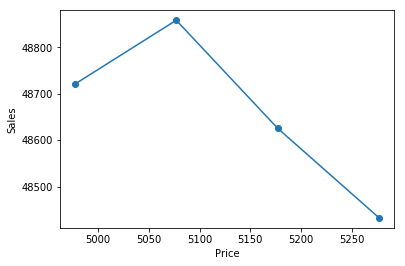

In [50]:
plt.plot(prices, sales, marker = 'o')
plt.xlabel('Price')
plt.ylabel('Sales')

In [72]:
def get_optimized_price_range(query):
    model = rf_full
    cur_price = start_price
    cur_sales, prev_sales = get_sales_pred(query, cur_price, model), 0
    change_points = []
    
    while len(change_points) < 2:
        if cur_sales < prev_sales:
            change_points.append((cur_price-100, prev_sales))

        prices.append(cur_price)
        sales.append(cur_sales)

        cur_price += 100
        prev_sales = cur_sales
        cur_sales = get_sales_pred(query, cur_price, model)
    
    return change_points[np.argmax(change_points, axis=0)[1]]

In [73]:
get_optimized_price_range(query)

(5077.0, 48858.39654277353)

In [131]:
model = rf_full

for _,query in query_df.iterrows():
    cur_price = start_price
    cur_sales, prev_sales = get_sales_pred(query, cur_price, model), 0

    while cur_sales > prev_sales:
        print(cur_price, cur_sales)
        cur_price += 100
        prev_sales = cur_sales
        cur_sales = get_sales_pred(query, cur_price, model)
    
    print('\n')


4977.0 [48574.32556021]


4977.0 [48981.84518068]


4977.0 [48527.85474091]




In [41]:
df[(df.day_of_month==1) & (df.month==1)].sort_values('year')

,Dep_Date,Days_to_Depart,Price,Comptt_Price_Median,Bookings,day_of_month,Difference_To_Market,year,Sales,month,weekday
0,2011-01-01,60,7541.0,7529.91,3.0,1,11.09,2011,22623.0,1,5
21912,2011-01-01,48,7580.0,7521.36,6.0,1,58.64,2011,45480.0,1,5
45650,2011-01-01,35,7855.0,7664.58,4.0,1,190.42,2011,31420.0,1,5
20086,2011-01-01,49,7623.0,8277.05,9.0,1,-654.05,2011,68607.0,1,5
47476,2011-01-01,34,7827.0,7987.26,5.0,1,-160.26,2011,39135.0,1,5
76692,2011-01-01,18,9104.0,9320.89,0.0,1,-216.89,2011,0.0,1,5
18260,2011-01-01,50,7642.0,7423.56,7.0,1,218.44,2011,53494.0,1,5
43824,2011-01-01,36,7840.0,7970.96,5.0,1,-130.96,2011,39200.0,1,5
49302,2011-01-01,33,7835.0,7424.07,4.0,1,410.93,2011,31340.0,1,5
51128,2011-01-01,32,8194.0,8139.34,9.0,1,54.66,2011,73746.0,1,5
